In [1]:
import torch
import torch.distributions as dist
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import json
from datetime import datetime


In [2]:
# CONFIG SAUVEGARDE 
SAVE = True  

def get_next_run_id(exp_dir: str) -> str:
    existing = [
        d for d in os.listdir(exp_dir)
        if d.isdigit() and len(d) == 3
    ]
    if not existing:
        return "001"
    return f"{int(max(existing)):03d}"

BASE_PATH = os.getcwd()
RUNS_ROOT = os.path.join(BASE_PATH, "runs_ncsn")
os.makedirs(RUNS_ROOT, exist_ok=True)

EXP_NAME = "gmm_baseline"
EXP_DIR = os.path.join(RUNS_ROOT, EXP_NAME)
os.makedirs(EXP_DIR, exist_ok=True)

RUN_ID = get_next_run_id(EXP_DIR)
RUN_DIR = os.path.join(EXP_DIR, RUN_ID)  # <- fix ici

if SAVE:
    os.makedirs(RUN_DIR, exist_ok=True)
    FIG_DIR = os.path.join(RUN_DIR, "figures")
    WEIGHTS_DIR = os.path.join(RUN_DIR, "weights")
    LOGS_DIR = os.path.join(RUN_DIR, "logs")
    os.makedirs(FIG_DIR, exist_ok=True)
    os.makedirs(WEIGHTS_DIR, exist_ok=True)
    os.makedirs(LOGS_DIR, exist_ok=True)
else:
    FIG_DIR = WEIGHTS_DIR = LOGS_DIR = None


In [3]:
torch.set_default_dtype(torch.float32)


if torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor
    
def t(x):
    # j'avais des problèmes de type avec les long 
    return torch.as_tensor(x, dtype=torch.get_default_dtype()).to(device)

print(device)


mps


## 1 GMM Dataset

In [4]:
mean = torch.stack(
    [
    t([-4,4]), # mean Gauss 1 
    t([4,-4]),  # mean Gauss 2 
    t([0,0])
    ]
    ,dim = 0
).to(device)

cov = torch.stack(
    [
        torch.eye(2)/10, # cov 
        torch.eye(2),  #cov 2
        torch.eye(2)/40
    ],
    dim = 0
).to(device)

weights = dist.Categorical(t([0.1,0.6,0.3]))
gaussians = dist.MultivariateNormal(mean,cov)
dataset = dist.MixtureSameFamily(weights,gaussians)

In [5]:
class ScoreNetworkConditionned(nn.Module): 
    
    def __init__(self, x_dim,hidden_dim = 128*2,sigma_emb_dim=20):
        super().__init__()
        
        self.sigma_embedding = nn.Sequential(
            nn.Linear(1,sigma_emb_dim),
            nn.ReLU(),
            nn.Linear(sigma_emb_dim,sigma_emb_dim),
            nn.ReLU(),
        )
        
        self.score_mlp = nn.Sequential(
            nn.Linear(x_dim + sigma_emb_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,x_dim)
        )
    def forward(self,x_noisy,sigma):
        """
        x_noisy: (B, x_dim)
        sigma: (B, 1)
        """
        
        assert sigma.dim() == 2 and sigma.shape[0] == x_noisy.shape[0] and sigma.shape[1] == 1, f"sigma doit être (B,1), reçu {sigma.shape}"
        log_sigma = torch.log(sigma)
        s_e = self.sigma_embedding(log_sigma)
        x_stack = torch.cat([x_noisy, s_e], dim=-1) 
        score = self.score_mlp(x_stack)
        return score
    
def LossNCSN(model,x,sigmas,eps_trainning = False):
    
    B,x_dim = x.shape
    
    idx_noise = torch.randint(0,len(sigmas),(B,)).to(device)
    sigma = sigmas[idx_noise].unsqueeze(-1)
    eps = torch.randn_like(x).to(device)
    x_noisy = x + sigma* eps # donc B écahntillons bruité 
    
    if eps_trainning : 
        f = model(x_noisy,sigma)
        # erreur epsilon
        err = (f + eps)**2                   # (B, x_dim)
        err = err.sum(dim=-1)                # (B,)

        # pondération critique pour ne pas sacrifier les petits σ :
        w = 1.0 / (sigma.squeeze(-1)**2 + 1e-12)  # (B,)
        loss = (w * err).mean()
        return loss

    else : 
        s = model(x_noisy,sigma)
        target = - eps/sigma
        
        lambda_i = sigma**2              # (B,1)
        loss_i = ((s - target)**2).sum(dim=-1, keepdim=True)  # (B,1)
        loss = (lambda_i * loss_i).mean()

        return loss


In [6]:
def construct_noise_linspace(min,max,L):
    return torch.linspace(min,max,L).flip(0).to(device)

def construct_noise_logspace(sigma_min,sigma_max,L):
    return torch.logspace(
        torch.log10(t(sigma_min)),
        torch.log10(t(sigma_max)),L
    ).flip(0).to(device)
    
def score(distrib,x):
    x = x.clone().detach().requires_grad_(True)
    lp = distrib.log_prob(x)
    score, = torch.autograd.grad(lp.sum(),x) # lp.sum() pour que si x a un batch_size ça marche.
    return score

def construct_GMM_noised_distribution(noise_list,loc,cov,weights):
    d = loc.size(-1)
    noised_distribution = []
    for sigma in noise_list : 
        g_noised = dist.MultivariateNormal(loc,cov + torch.eye(d,device=device)*sigma**2)
        noised_distribution.append(dist.MixtureSameFamily(weights,g_noised))
    return noised_distribution

def make_true_score(d):
    return lambda x: score(d, x)


def make_score_from_model(model, sigma_scalar,eps_loss = False):
    sigma_scalar = float(sigma_scalar)
    
    @torch.no_grad()
    def score(x):
        # x: (B, x_dim)
        B = x.shape[0]
        sigma = x.new_full((B, 1), sigma_scalar)   # (B,1) 
        return model(x, sigma)
    @torch.no_grad()
    def score_eps(x):
       # x: (B, x_dim)
        B = x.shape[0]
        sigma = x.new_full((B, 1), sigma_scalar)   # (B,1) 
        return model(x, sigma) /sigma
    if eps_loss : 
        return score_eps
    else : 
        return score


def compute_MSE(true_noised_dist, estimated_score_list, sigmas, n_sample):
    B = n_sample
    MSE = []
    erreurRelative = []

    for i, s in enumerate(sigmas):
        
        x = true_noised_dist[i].sample((B,)).to(device)

        # prédiction modèle SANS GRADIENT pour pas avoir de pb pendant le trainning
        with torch.no_grad():
            pred = estimated_score_list[i](x)    # (B, d)

        # true score AVEC autograd mais sur un x qui ne touche pas le modèle
        x_req = x.detach().clone().requires_grad_(True)
        lp = true_noised_dist[i].log_prob(x_req)
        target, = torch.autograd.grad(lp.sum(), x_req)
        # pas besoin de garder le graph :
        target = target.detach()

        #  MSE + erreur relative
        mse_mean = ((pred - target)**2).sum(dim=-1).mean().item()
        target_norm_mean = (target**2).sum(dim=-1).mean().item()
        relative_error = mse_mean / (target_norm_mean + 1e-12)

        MSE.append(mse_mean)
        erreurRelative.append(100 * relative_error)

    return MSE, erreurRelative


In [7]:
ALD_prior_mean = [0.0, 0.0]
ALD_prior_cov_scalar = 3       
ALD_step_size = 0.2
ALD_T = 2000
ALD_n_chain = 2000

batch_size = 4 * 128
N_train = 40000
EVAL_EVERY = 5000
lr = 1e-4
HIDDEN_DIM = 4*128
SIGMA_EMB_DIM = 20

# Sigma config
SIGMA_MIN = 1e-1          
SIGMA_MAX = 5
N_SIGMAS = 10
SIGMA_SCHEDULE = "log"    # ou "lin"
EPS_TRAINNING = False     

# affichage
PLOT_VECTOR_FIELD_NORM = '0.5 + 25*i/n_sigma'

if SIGMA_SCHEDULE == "log":
    sigmas = construct_noise_logspace(SIGMA_MIN, SIGMA_MAX, N_SIGMAS)
elif SIGMA_SCHEDULE == "lin":
    sigmas = construct_noise_linspace(SIGMA_MIN, SIGMA_MAX, N_SIGMAS)
else:
    raise ValueError(f"Unknown SIGMA_SCHEDULE: {SIGMA_SCHEDULE}")

x_dim = dataset.sample().shape[-1]
true_noised_dist = construct_GMM_noised_distribution(noise_list=sigmas,loc=mean,cov=cov,weights=weights)
true_distribution_scores = [make_true_score(d) for d in true_noised_dist]
model = ScoreNetworkConditionned(x_dim=x_dim,hidden_dim=HIDDEN_DIM,sigma_emb_dim=SIGMA_EMB_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# SAUVEGARDE des HYPERPARAMS 
if SAVE:
    hparams = {
    "batch_size": batch_size,
    "N_train": N_train,
    "EVAL_EVERY": EVAL_EVERY,
    "lr": lr,
    "EPS_TRAINNING": EPS_TRAINNING,
    "sigma": {
        "schedule": SIGMA_SCHEDULE,
        "min": SIGMA_MIN,
        "max": SIGMA_MAX,
        "n_sigmas": N_SIGMAS,
        "values": [float(s) for s in sigmas],
    },
    "ALD": {
        "prior_mean": ALD_prior_mean,
        "prior_cov_scalar": ALD_prior_cov_scalar,
        "step_size": float(ALD_step_size),
        "T": ALD_T,
        "n_chain": ALD_n_chain,
    },
    "device": str(device),
    "model": {
        "hidden_dim": HIDDEN_DIM,
        "sigma_emb_dim": SIGMA_EMB_DIM,
    },
    'plot scores renormalisation' : PLOT_VECTOR_FIELD_NORM,
}


with open(os.path.join(LOGS_DIR, "hparams.json"), "w") as f:
    json.dump(hparams, f, indent=4)


In [8]:
model.train()
L = []
MSE_list = []
ER = []
eval_steps = []

for step in range(N_train):
    x = dataset.sample((batch_size,)).to(device)
    optimizer.zero_grad()

    loss = LossNCSN(model, x, sigmas, EPS_TRAINNING)
    loss.backward()
    optimizer.step()
    L.append(loss.item())
    
    if (step + 1) % EVAL_EVERY == 0 or step==N_train-1:
        model.eval()
        estimated_distribution_scores = [make_score_from_model(model, noise, EPS_TRAINNING)for noise in list(sigmas)]
        MSE, err_rel = compute_MSE(true_noised_dist,estimated_distribution_scores,sigmas,n_sample=5000)
        MSE_list.append(MSE)
        ER.append(err_rel)
        eval_steps.append(step+1)

        print(f"[{step+1}/{N_train}] train loss (last 500) = {np.mean(L[-500:]):.4f}")
        print(" relative errors (%):", [f"{e:.1f}" for e in err_rel])
        # saving des poids en cours de route
        if SAVE : 
            torch.save(model.state_dict(), os.path.join(WEIGHTS_DIR, "model.pt"))
        model.train()

# SAUVEGARDE METRICS BRUTES 
if SAVE:
    np.save(os.path.join(LOGS_DIR, "train_loss.npy"), np.array(L))
    np.save(os.path.join(LOGS_DIR, "steps_eval.npy"), np.array(eval_steps))
    np.save(os.path.join(LOGS_DIR, "MSE.npy"), np.asarray(MSE_list))
    np.save(os.path.join(LOGS_DIR, "ER.npy"), np.asarray(ER))

    # Poids du modèle
    torch.save(model.state_dict(), os.path.join(WEIGHTS_DIR, "model.pt"))


[5000/40000] train loss (last 500) = 1.0677
 relative errors (%): ['3.8', '0.9', '0.8', '0.5', '1.2', '3.7', '5.4', '6.6', '12.4', '24.0']
[10000/40000] train loss (last 500) = 1.0452
 relative errors (%): ['1.4', '0.7', '0.4', '0.5', '0.7', '0.8', '1.3', '2.6', '3.4', '5.3']
[15000/40000] train loss (last 500) = 1.0445
 relative errors (%): ['0.8', '0.3', '0.4', '0.4', '0.5', '0.4', '0.8', '1.5', '2.1', '2.8']
[20000/40000] train loss (last 500) = 1.0478
 relative errors (%): ['0.6', '0.3', '0.2', '0.4', '0.5', '0.5', '0.4', '0.4', '0.6', '1.6']
[25000/40000] train loss (last 500) = 1.0436
 relative errors (%): ['0.3', '0.1', '0.3', '0.3', '0.3', '0.3', '0.4', '0.2', '0.4', '1.5']
[30000/40000] train loss (last 500) = 1.0442
 relative errors (%): ['0.7', '0.3', '0.5', '0.3', '0.3', '0.4', '0.4', '0.4', '0.5', '0.9']
[35000/40000] train loss (last 500) = 1.0360
 relative errors (%): ['0.1', '0.1', '0.2', '0.2', '0.2', '0.3', '0.3', '0.3', '0.3', '0.5']
[40000/40000] train loss (last 50

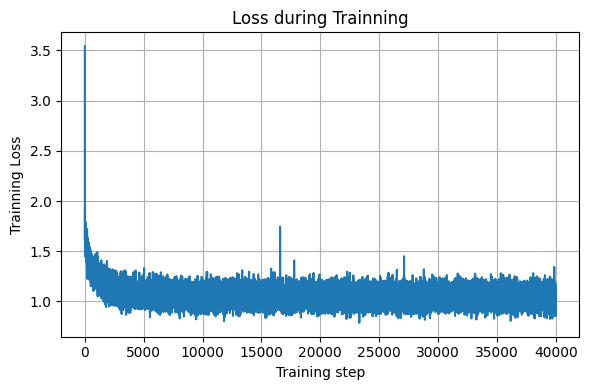

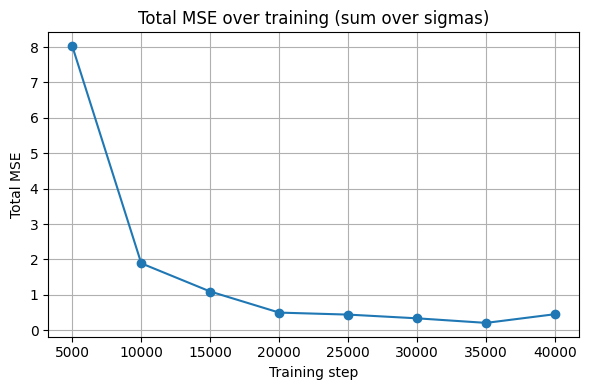

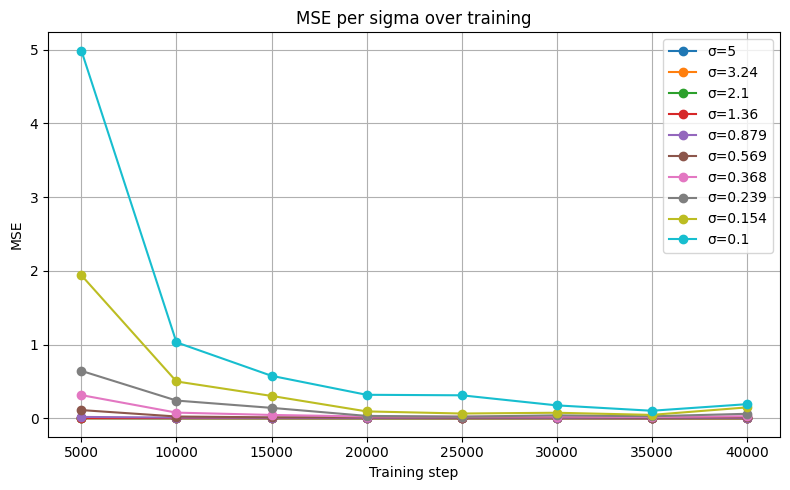

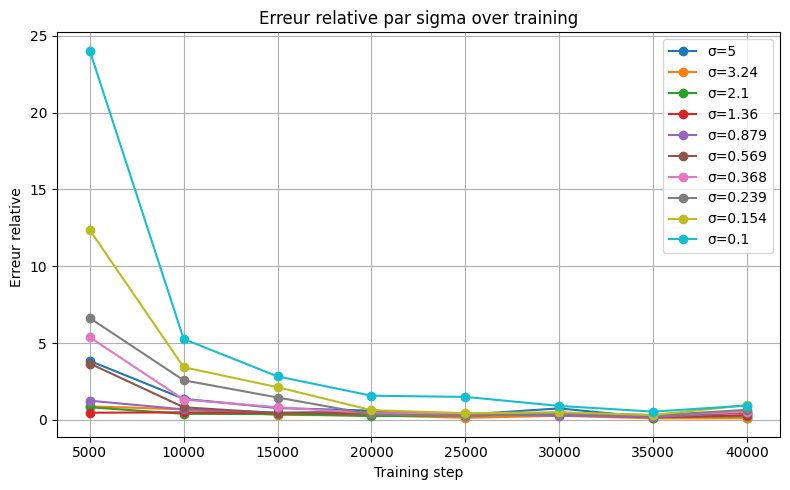

In [9]:
MSE_arr = np.asarray(MSE_list)  # shape: (n_checkpoints, n_sigmas)
ER_arr = np.asarray(ER)
steps = np.asarray(eval_steps)

total_MSE = MSE_arr.sum(axis=1)

plt.figure(figsize=(6,4))
plt.title('Loss during Trainning')
plt.plot(L)
plt.xlabel("Training step")
plt.ylabel("Trainning Loss")
plt.grid(True)
plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(FIG_DIR, "train_loss.png"), dpi=200)
plt.show()


plt.figure(figsize=(6,4))
plt.plot(steps, total_MSE, marker='o')
plt.title("Total MSE over training (sum over sigmas)")
plt.xlabel("Training step")
plt.ylabel("Total MSE")
plt.grid(True)
plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(FIG_DIR, "total_MSE.png"), dpi=200)
plt.show()

# MSE par sigma
plt.figure(figsize=(8,5))
for j, s in enumerate(sigmas):
    plt.plot(steps, MSE_arr[:, j], marker='o', label=f"σ={float(s):.3g}")

plt.title("MSE per sigma over training")
plt.xlabel("Training step")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(FIG_DIR, "MSE_per_sigma.png"), dpi=200)
plt.show()

# Erreur relative par sigma
plt.figure(figsize=(8,5))
for j, s in enumerate(sigmas):
    plt.plot(steps, ER_arr[:, j], marker='o', label=f"σ={float(s):.3g}")

plt.title("Erreur relative par sigma over training")
plt.xlabel("Training step")
plt.ylabel("Erreur relative ")
plt.legend()
plt.grid(True)
plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(FIG_DIR, "ER_per_sigma.png"), dpi=200)
plt.show()


In [10]:
model.eval()
estimated_distribution_scores = [make_score_from_model(model,noise,EPS_TRAINNING) for noise in list(sigmas)]

### Performances quantitative : 

- Comme on connait le score pour un GMM on peut regarder la vrai erreur que l'on fait. 

 

In [11]:

def plot_scores_as_vectors(true_score,estimated_score,sigmas):
    # true score : list of scores(x)
    # estimated score : list of scores(x)
    n_points = 20
    x_min,x_max = -10,10
    xc = torch.linspace(x_min,x_max,n_points,device=device)
    yc = torch.linspace(x_min,x_max,n_points,device=device)
    
    X,Y = torch.meshgrid([xc,yc],indexing='ij')
    coords = torch.stack([X, Y], dim=-1)      # (n_points, n_points, 2)
    coords_flat = coords.view(-1, 2)          # (B, 2) avec B = n_points**2
    B = coords_flat.shape[0]
    nrows = len(sigmas)
    fig, axes = plt.subplots(nrows=nrows, ncols=2,
                         figsize=(10, 4*nrows),
                         squeeze=False)
    
    for i,s in enumerate(sigmas) : 
        
        true_score_flat_i = true_score[i](coords_flat)
        estimated_score_flat_i = estimated_score[i](coords_flat)
        
        true_score_i = true_score_flat_i.view(n_points, n_points, 2)
        estimated_score_i = estimated_score_flat_i.view(n_points,n_points,2)  
        
        Sx_TS = true_score_i[...,0].cpu().detach()
        Sy_TS = true_score_i[...,1].cpu().detach()
        Sx_ES = estimated_score_i[...,0].cpu().detach()
        Sy_ES = estimated_score_i[...,1].cpu().detach()
        
        X_cpu = X.cpu()
        Y_cpu = Y.cpu()

        ax_true = axes[i, 0]
        ax_est  = axes[i, 1]

        ax_true.set_xlim(x_min, x_max)
        ax_true.set_ylim(x_min, x_max)
        h = np.log(25)/nrows
        scale1 = 0.5 + 25*i/nrows
        scale2 = 0.5 + -1 +  np.exp(h*i)
        ax_true.quiver(X_cpu, Y_cpu, Sx_TS, Sy_TS,angles='xy', scale_units='xy', scale=scale1) # j'adapte juste le rescaling pour que l'on voit quelque chose à toute les échelles
        ax_true.set_aspect('equal')
        ax_true.set_title(f"True Score, sigma={float(s):.3f}")

        ax_est.set_xlim(x_min, x_max)
        ax_est.set_ylim(x_min, x_max)
        ax_est.quiver(X_cpu, Y_cpu, Sx_ES, Sy_ES, angles='xy', scale_units='xy', scale=scale1)
        ax_est.set_aspect('equal')
        ax_est.set_title(f"Estimated Score, sigma={float(s):.3f}")
    
    if SAVE:
        plt.savefig(os.path.join(FIG_DIR, "scores_vectors.png"), dpi=200)
    
    plt.show()  

def plot_scores_norm(true_score,estimated_score,sigmas):
    # true score : list of scores(x)
    # estimated score : list of scores(x)
    n_points = 100
    x_min,x_max = -10,10
    xc = torch.linspace(x_min,x_max,n_points,device=device)
    yc = torch.linspace(x_min,x_max,n_points,device=device) 
    X,Y = torch.meshgrid([xc,yc],indexing='ij')
    coords = torch.stack([X, Y], dim=-1)      # (n_points, n_points, 2)
    coords_flat = coords.view(-1, 2)          # (B, 2) avec B = n_points**2
    B = coords_flat.shape[0]
    nrows = len(sigmas)
    fig, axes = plt.subplots(nrows=nrows, ncols=2,
                         figsize=(10, 4*nrows),
                         squeeze=False)
    
    for i,s in enumerate(sigmas) : 
        
        true_score_flat_i = true_score[i](coords_flat)
        estimated_score_flat_i = estimated_score[i](coords_flat)
        
        true_score_i = true_score_flat_i.view(n_points, n_points, 2)
        estimated_score_i = estimated_score_flat_i.view(n_points,n_points,2)  
        mag_ts = torch.linalg.norm(true_score_i, dim=-1).cpu()
        mag_es = torch.linalg.norm(estimated_score_i, dim=-1).cpu().detach()
        eps = 1e-8
        log_mag_ts = (mag_ts + eps).log10()
        log_mag_es = (mag_es + eps).log10()
        
        
        X_cpu = X.cpu()
        Y_cpu = Y.cpu()

        ax_true = axes[i, 0]
        ax_est  = axes[i, 1]

        ax_true.set_xlim(x_min, x_max)
        ax_true.set_ylim(x_min, x_max)
        im0 = ax_true.imshow(
        log_mag_ts,
        origin='lower',
        extent=[x_min, x_max, x_min, x_max]
        )
        
        ax_true.set_title(f"||True score||, sigma={float(s):.2f}")
        plt.colorbar(im0, ax=ax_true)
        
        ax_est.set_xlim(x_min, x_max)
        ax_est.set_ylim(x_min, x_max)
        im1 = ax_est.imshow(
        log_mag_es,
        origin='lower',
        extent=[x_min, x_max, x_min, x_max]
        )
        ax_est.set_title(f"||Estimated Score||, sigma={float(s):.2f}")
        plt.colorbar(im1, ax=ax_est)

    if SAVE:
        plt.savefig(os.path.join(FIG_DIR, "scores_norm.png"), dpi=200)
    plt.show()

### Performances visuelles

- 1er graphique : 
        pour chaque niveau de bruit
        true score vs estimated score (vector field)
        Pour chaque échelle les vecteurs sont normalisés différement pour pouvoir bien visualiser leur direction. 

- 2eme graphique : 
        pour chaque niveau de bruit
        norme true score vs norme estimated score 

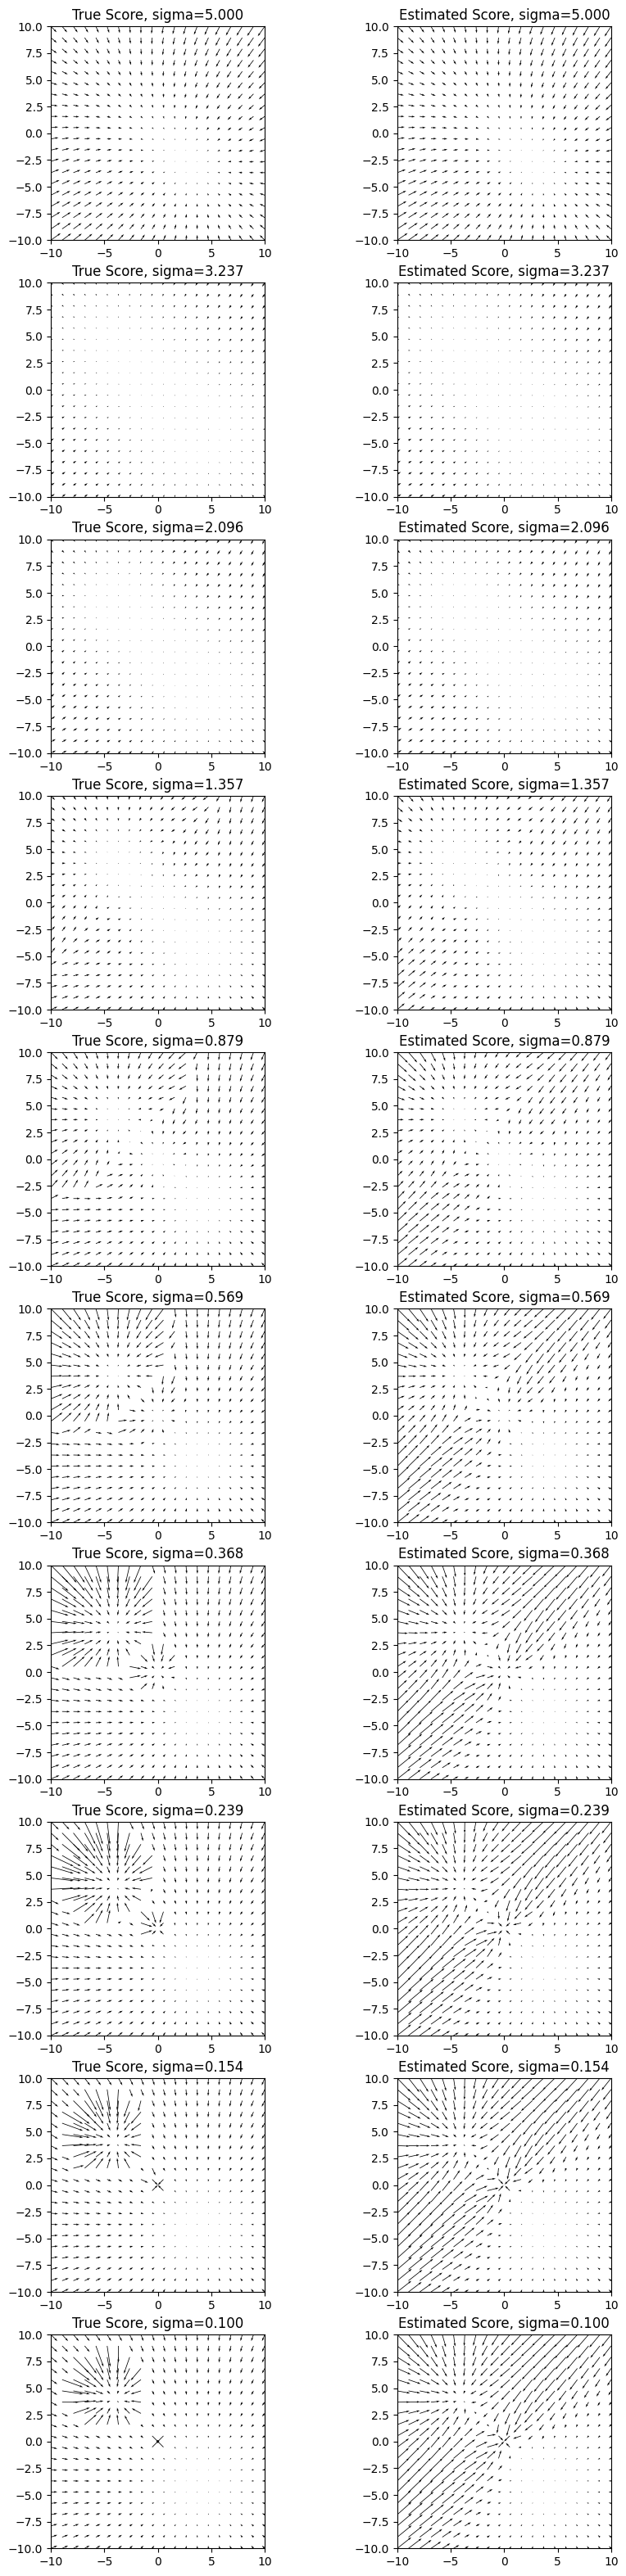

In [12]:
plot_scores_as_vectors(true_distribution_scores,estimated_distribution_scores,sigmas)

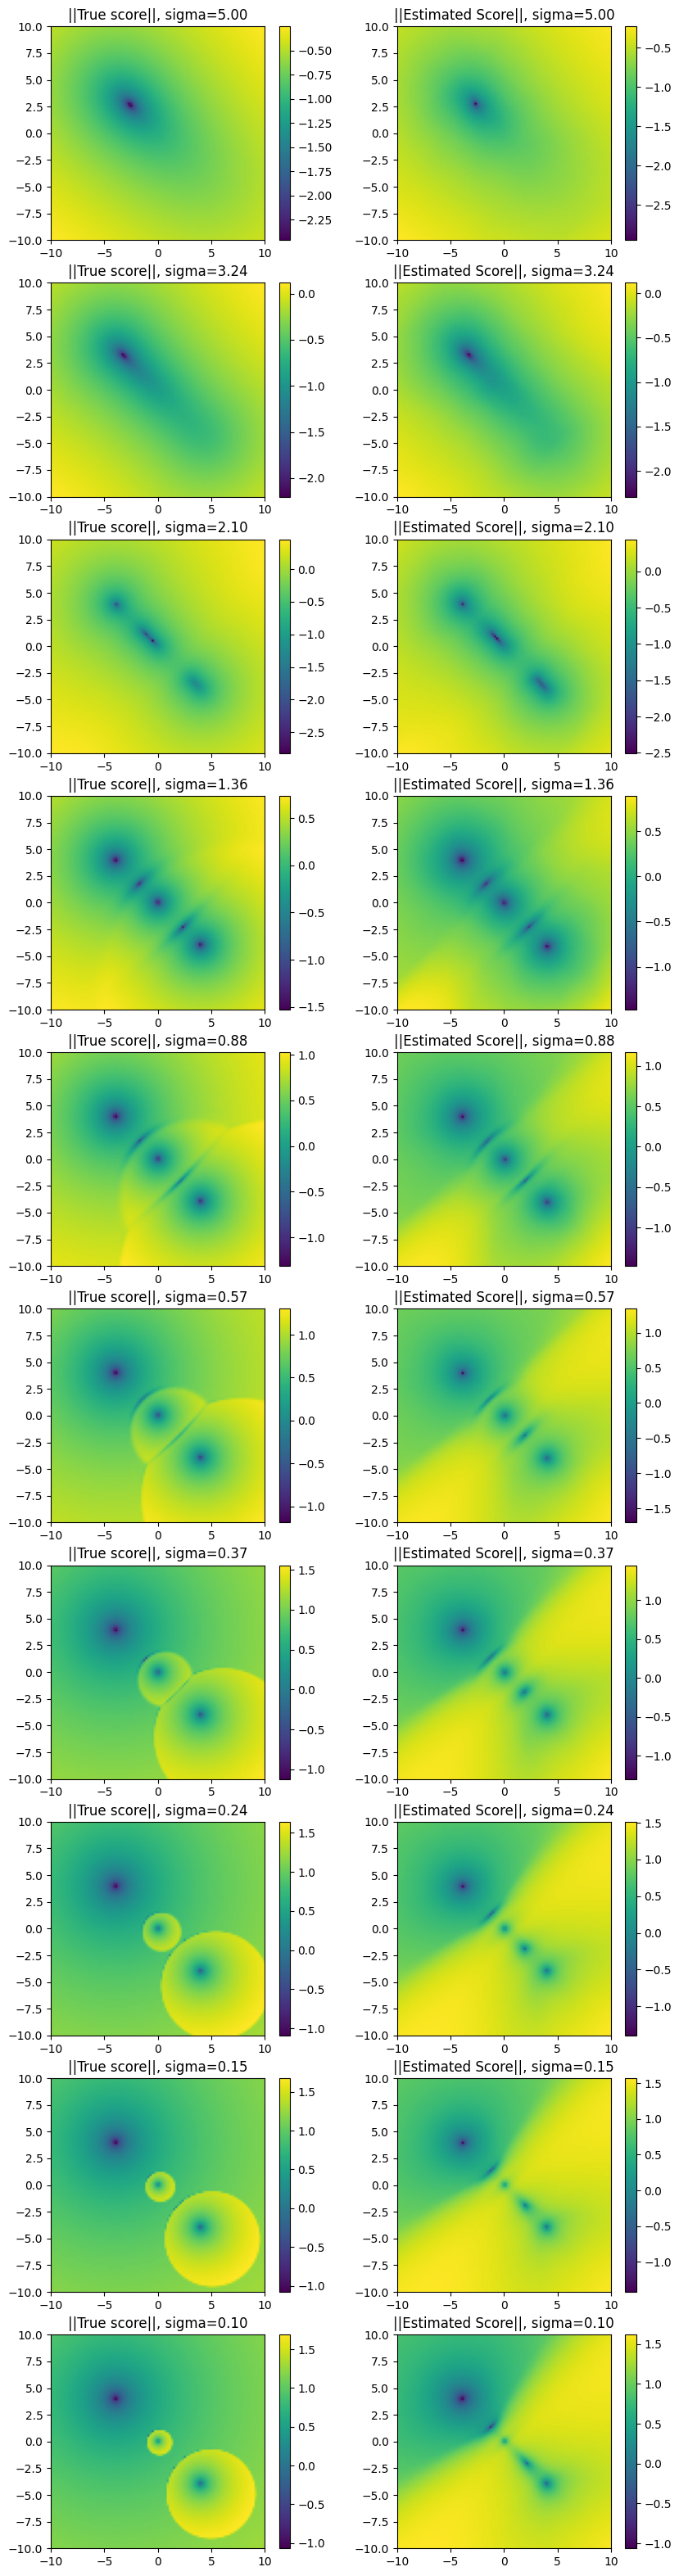

In [13]:
plot_scores_norm(true_distribution_scores,estimated_distribution_scores,sigmas)

## Annealed Langevin Sampling 

In [14]:
def annealded_langevin_sampler(prior,noisy_distrib_scores,noise_factor,step_size,T,n_chain):
    X = prior.sample((n_chain,)).to(device)
    U = dist.MultivariateNormal(loc = t([0,0]),covariance_matrix=torch.eye(2,device=device))
    for i in range(len(noisy_distrib_scores)):
        tau = step_size * noise_factor[i]
        for _ in range(T):
            X = X + tau*noisy_distrib_scores[i](X) + torch.sqrt(t(2*tau))*U.sample((n_chain,))
    return X 


In [15]:
prior_mean = t(ALD_prior_mean)
prior_var = ALD_prior_cov_scalar * torch.eye(2).to(device)
prior_distrib = dist.MultivariateNormal(prior_mean, covariance_matrix=prior_var)

# ald estimated score
ALD_estimated_score = annealded_langevin_sampler(
    prior_distrib,
    estimated_distribution_scores,
    sigmas,
    t(ALD_step_size),
    ALD_T,
    ALD_n_chain
)

# ald true score
ALD_true_score = annealded_langevin_sampler(
    prior_distrib,
    true_distribution_scores,
    sigmas,
    t(ALD_step_size),
    ALD_T,
    ALD_n_chain 
)


In [16]:
true_samples = dataset.sample((ALD_n_chain,)).cpu()
ALD_ES_cpu = ALD_true_score.cpu()
ALD_TS_cpu = ALD_estimated_score.cpu()

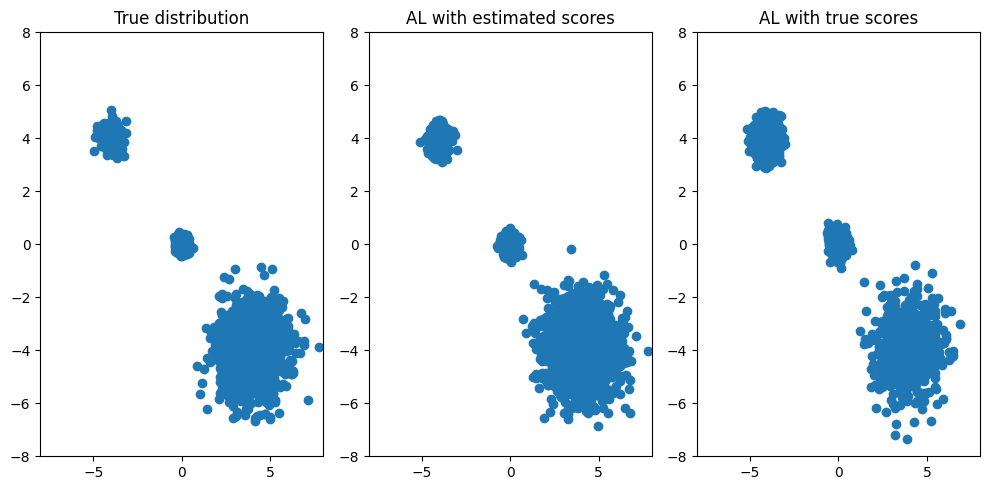

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.scatter(true_samples.T[0],true_samples.T[1])

plt.title("True distribution")
plt.subplot(1,3,2)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.title('AL with estimated scores')
plt.scatter(ALD_ES_cpu.T[0],ALD_ES_cpu.T[1])

plt.subplot(1,3,3)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.title('AL with true scores')
plt.scatter(ALD_TS_cpu.T[0],ALD_TS_cpu.T[1])
if SAVE:
    plt.savefig(os.path.join(FIG_DIR, "ALD.png"), dpi=200)
plt.tight_layout()
plt.show()

